# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
def create_vit_model(num_classes=4, pretrained=True, model_type='b16'):
    """
    Create Vision Transformer model for multi-class classification
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
        model_type (str): Type of ViT model - 'b16' or 'b32'
    
    Returns:
        model: Vision Transformer model
    """
    if model_type.lower() == 'b16':
        model = models.vit_b_16(pretrained=pretrained)
    elif model_type.lower() == 'b32':
        model = models.vit_b_32(pretrained=pretrained)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Choose 'b16' or 'b32'")
    
    # Modify classifier head
    num_features = model.heads.head.in_features
    model.heads.head = nn.Linear(num_features, num_classes)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ViT-B/16

Training Vision Transformer B/16


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 233MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.55it/s, Loss=1.5558, Acc=0.3125]


Train Loss: 1.5558 Acc: 0.3125 Macro-F1: 0.2674


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=1.4644, Acc=0.2072]


Val Loss: 1.4644 Acc: 0.2072 Macro-F1: 0.1455
✓ New best model saved with validation macro-F1: 0.1455

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.2925, Acc=0.3388]


Train Loss: 1.2925 Acc: 0.3388 Macro-F1: 0.3168


Val : 100%|██████████| 10/10 [00:02<00:00,  4.59it/s, Loss=1.1560, Acc=0.4704]


Val Loss: 1.1560 Acc: 0.4704 Macro-F1: 0.3690
✓ New best model saved with validation macro-F1: 0.3690

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.2766, Acc=0.4030]


Train Loss: 1.2766 Acc: 0.4030 Macro-F1: 0.3667


Val : 100%|██████████| 10/10 [00:02<00:00,  4.54it/s, Loss=1.1672, Acc=0.4342]


Val Loss: 1.1672 Acc: 0.4342 Macro-F1: 0.3660

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.2173, Acc=0.4490]


Train Loss: 1.2173 Acc: 0.4490 Macro-F1: 0.4095


Val : 100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Loss=1.0682, Acc=0.4507]


Val Loss: 1.0682 Acc: 0.4507 Macro-F1: 0.3764
✓ New best model saved with validation macro-F1: 0.3764

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.1259, Acc=0.4630]


Train Loss: 1.1259 Acc: 0.4630 Macro-F1: 0.4406


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=1.0361, Acc=0.4803]


Val Loss: 1.0361 Acc: 0.4803 Macro-F1: 0.4045
✓ New best model saved with validation macro-F1: 0.4045

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.1012, Acc=0.4786]


Train Loss: 1.1012 Acc: 0.4786 Macro-F1: 0.4456


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=1.1805, Acc=0.4145]


Val Loss: 1.1805 Acc: 0.4145 Macro-F1: 0.3486

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.0822, Acc=0.4934]


Train Loss: 1.0822 Acc: 0.4934 Macro-F1: 0.4569


Val : 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Loss=1.2133, Acc=0.4243]


Val Loss: 1.2133 Acc: 0.4243 Macro-F1: 0.3789

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.0017, Acc=0.5312]


Train Loss: 1.0017 Acc: 0.5312 Macro-F1: 0.5017


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=0.8778, Acc=0.6184]


Val Loss: 0.8778 Acc: 0.6184 Macro-F1: 0.5787
✓ New best model saved with validation macro-F1: 0.5787

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.9056, Acc=0.5847]


Train Loss: 0.9056 Acc: 0.5847 Macro-F1: 0.5476


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.8392, Acc=0.6283]


Val Loss: 0.8392 Acc: 0.6283 Macro-F1: 0.5868
✓ New best model saved with validation macro-F1: 0.5868

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.8690, Acc=0.6094]


Train Loss: 0.8690 Acc: 0.6094 Macro-F1: 0.5760


Val : 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Loss=0.8659, Acc=0.5724]


Val Loss: 0.8659 Acc: 0.5724 Macro-F1: 0.5393

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.8453, Acc=0.6151]


Train Loss: 0.8453 Acc: 0.6151 Macro-F1: 0.5800


Val : 100%|██████████| 10/10 [00:02<00:00,  4.50it/s, Loss=0.8150, Acc=0.6513]


Val Loss: 0.8150 Acc: 0.6513 Macro-F1: 0.6209
✓ New best model saved with validation macro-F1: 0.6209

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.8071, Acc=0.6439]


Train Loss: 0.8071 Acc: 0.6439 Macro-F1: 0.6030


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=0.7624, Acc=0.6579]


Val Loss: 0.7624 Acc: 0.6579 Macro-F1: 0.6193

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.7615, Acc=0.6579]


Train Loss: 0.7615 Acc: 0.6579 Macro-F1: 0.6233


Val : 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Loss=0.8053, Acc=0.6447]


Val Loss: 0.8053 Acc: 0.6447 Macro-F1: 0.6122

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.7586, Acc=0.6678]


Train Loss: 0.7586 Acc: 0.6678 Macro-F1: 0.6318


Val : 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, Loss=0.7428, Acc=0.6612]


Val Loss: 0.7428 Acc: 0.6612 Macro-F1: 0.6202

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.7139, Acc=0.6743]


Train Loss: 0.7139 Acc: 0.6743 Macro-F1: 0.6366


Val : 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, Loss=0.7254, Acc=0.6678]


Val Loss: 0.7254 Acc: 0.6678 Macro-F1: 0.6335
✓ New best model saved with validation macro-F1: 0.6335

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6841, Acc=0.6924]


Train Loss: 0.6841 Acc: 0.6924 Macro-F1: 0.6555


Val : 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, Loss=0.7145, Acc=0.6645]


Val Loss: 0.7145 Acc: 0.6645 Macro-F1: 0.6294

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6761, Acc=0.7007]


Train Loss: 0.6761 Acc: 0.7007 Macro-F1: 0.6623


Val : 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, Loss=0.7095, Acc=0.6809]


Val Loss: 0.7095 Acc: 0.6809 Macro-F1: 0.6466
✓ New best model saved with validation macro-F1: 0.6466

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6724, Acc=0.7015]


Train Loss: 0.6724 Acc: 0.7015 Macro-F1: 0.6696


Val : 100%|██████████| 10/10 [00:02<00:00,  4.51it/s, Loss=0.7026, Acc=0.6743]


Val Loss: 0.7026 Acc: 0.6743 Macro-F1: 0.6395

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6585, Acc=0.7105]


Train Loss: 0.6585 Acc: 0.7105 Macro-F1: 0.6750


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=0.6926, Acc=0.6776]


Val Loss: 0.6926 Acc: 0.6776 Macro-F1: 0.6396

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6628, Acc=0.7089]


Train Loss: 0.6628 Acc: 0.7089 Macro-F1: 0.6745


Val : 100%|██████████| 10/10 [00:02<00:00,  4.50it/s, Loss=0.7220, Acc=0.6809]


Val Loss: 0.7220 Acc: 0.6809 Macro-F1: 0.6507
✓ New best model saved with validation macro-F1: 0.6507

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6559, Acc=0.7130]


Train Loss: 0.6559 Acc: 0.7130 Macro-F1: 0.6791


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=0.6832, Acc=0.6941]


Val Loss: 0.6832 Acc: 0.6941 Macro-F1: 0.6594
✓ New best model saved with validation macro-F1: 0.6594

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6383, Acc=0.7188]


Train Loss: 0.6383 Acc: 0.7188 Macro-F1: 0.6841


Val : 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Loss=0.6820, Acc=0.6908]


Val Loss: 0.6820 Acc: 0.6908 Macro-F1: 0.6585

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6361, Acc=0.7179]


Train Loss: 0.6361 Acc: 0.7179 Macro-F1: 0.6848


Val : 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Loss=0.6840, Acc=0.6875]


Val Loss: 0.6840 Acc: 0.6875 Macro-F1: 0.6552

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6306, Acc=0.7163]


Train Loss: 0.6306 Acc: 0.7163 Macro-F1: 0.6817


Val : 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Loss=0.6795, Acc=0.6842]


Val Loss: 0.6795 Acc: 0.6842 Macro-F1: 0.6487

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=0.6260, Acc=0.7204]


Train Loss: 0.6260 Acc: 0.7204 Macro-F1: 0.6866


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=0.6800, Acc=0.6842]


Val Loss: 0.6800 Acc: 0.6842 Macro-F1: 0.6487

Training complete in 10m 52s
Best validation macro-F1: 0.6594


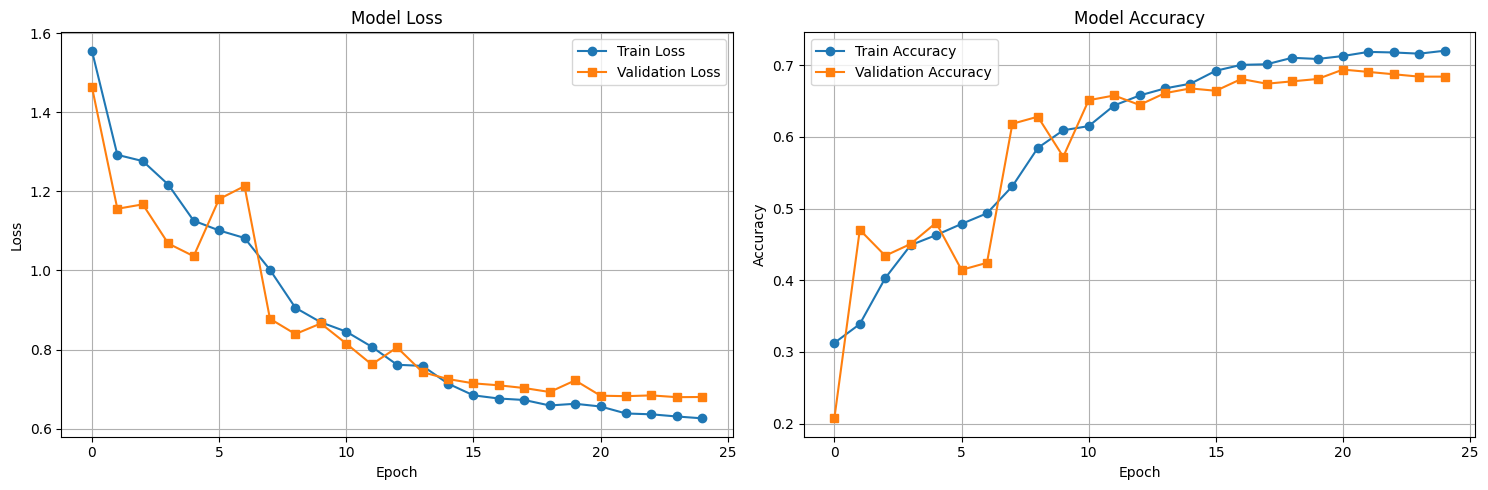

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Test Accuracy: 31.75%
Test Loss: 1.6936

Classification Report:
              precision    recall  f1-score   support

         HGC       0.55      0.28      0.38        74
         LGC       0.07      0.04      0.05        53
         NST       0.30      0.35      0.33        37
         NTL       0.30      0.96      0.46        25

    accuracy                           0.32       189
   macro avg       0.31      0.41      0.30       189
weighted avg       0.34      0.32      0.29       189


Confusion Matrix:
[[21 27 22  4]
 [17  2  7 27]
 [ 0  0 13 24]
 [ 0  0  1 24]]

ROC-AUC Scores:
Macro-average AUC: 0.6722
Micro-average AUC: 0.6706
HGC AUC: 0.8195
LGC AUC: 0.2847
NST AUC: 0.7504
NTL AUC: 0.8344


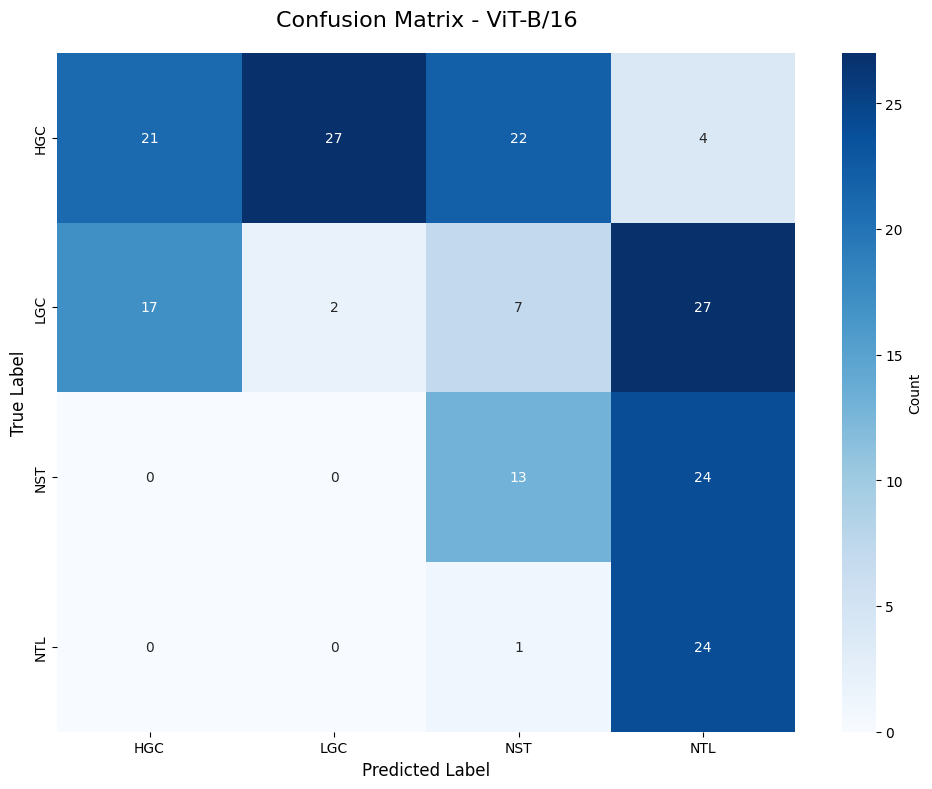

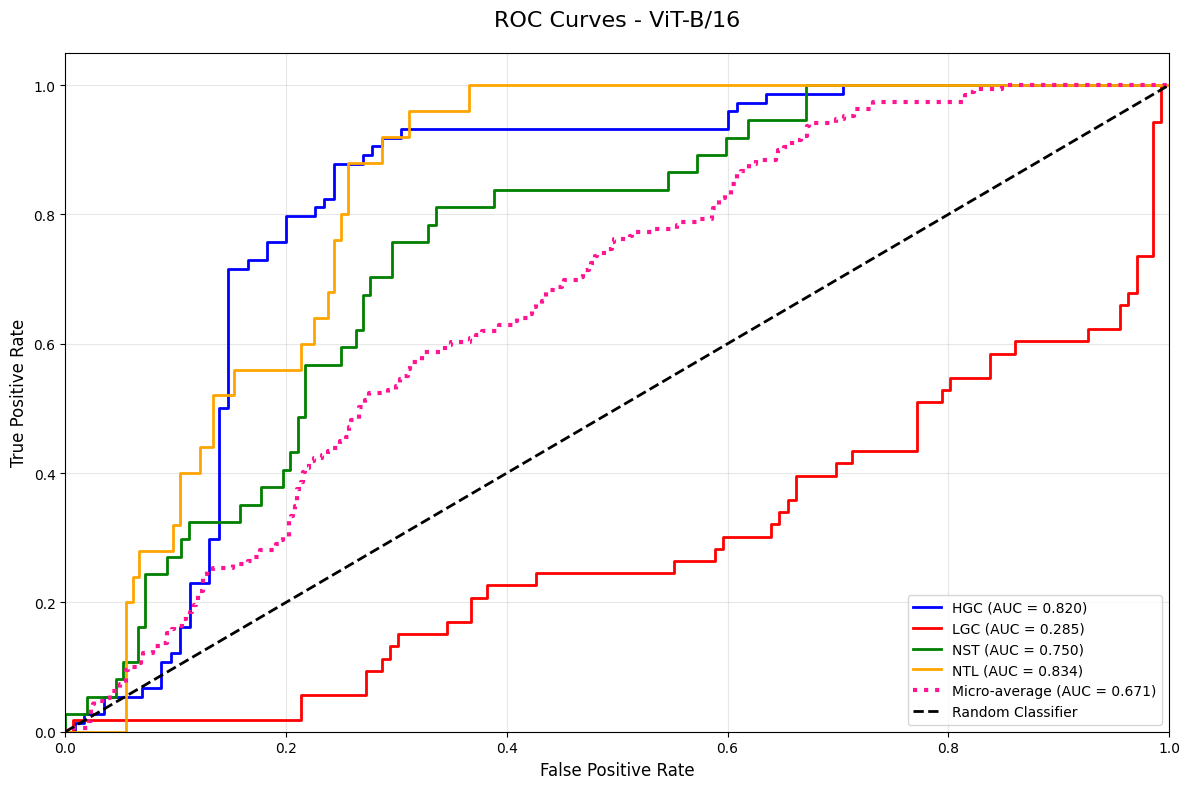


ViT-B/16 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training Vision Transformer B/16")
print("=" * 80)

# Create model
vit_b16 = create_vit_model(num_classes=4, pretrained=True, model_type='b16')

# Create trainer
trainer_vit_b16 = ModelTrainer(vit_b16, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vit_b16 = trainer_vit_b16.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ViT-B16")

# Plot training history
trainer_vit_b16.plot_training_history(save_path='vit_b16_training_history.png')

# Evaluate model
results_vit_b16 = trainer_vit_b16.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vit_b16['confusion_matrix'], class_names, 'ViT-B/16',
                      save_path='vit_b16_confusion_matrix.png')

# Plot ROC curves
roc_auc_vit_b16 = plot_roc_curves(results_vit_b16['labels'], results_vit_b16['probabilities'], class_names, 'ViT-B/16',
                                   save_path='vit_b16_roc_curves.png')

# Store results
results_vit_b16['model_name'] = 'ViT-B/16'
results_vit_b16['roc_auc'] = roc_auc_vit_b16
all_results.append(results_vit_b16)

print("\nViT-B/16 training and evaluation complete!")

## Train ViT-B/32

Training Vision Transformer B/32


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


100%|██████████| 337M/337M [00:01<00:00, 243MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.68it/s, Loss=1.6697, Acc=0.3380]


Train Loss: 1.6697 Acc: 0.3380 Macro-F1: 0.3100


Val : 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Loss=1.5646, Acc=0.0789]


Val Loss: 1.5646 Acc: 0.0789 Macro-F1: 0.0456
✓ New best model saved with validation macro-F1: 0.0456

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=1.3072, Acc=0.3997]


Train Loss: 1.3072 Acc: 0.3997 Macro-F1: 0.3630


Val : 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Loss=1.2792, Acc=0.3980]


Val Loss: 1.2792 Acc: 0.3980 Macro-F1: 0.2209
✓ New best model saved with validation macro-F1: 0.2209

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.71it/s, Loss=1.2720, Acc=0.4095]


Train Loss: 1.2720 Acc: 0.4095 Macro-F1: 0.3802


Val : 100%|██████████| 10/10 [00:01<00:00,  9.51it/s, Loss=1.0757, Acc=0.5296]


Val Loss: 1.0757 Acc: 0.5296 Macro-F1: 0.4278
✓ New best model saved with validation macro-F1: 0.4278

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.66it/s, Loss=1.1807, Acc=0.4474]


Train Loss: 1.1807 Acc: 0.4474 Macro-F1: 0.4153


Val : 100%|██████████| 10/10 [00:01<00:00,  9.52it/s, Loss=1.0831, Acc=0.4967]


Val Loss: 1.0831 Acc: 0.4967 Macro-F1: 0.4436
✓ New best model saved with validation macro-F1: 0.4436

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.69it/s, Loss=1.1705, Acc=0.4498]


Train Loss: 1.1705 Acc: 0.4498 Macro-F1: 0.4169


Val : 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Loss=1.0984, Acc=0.4967]


Val Loss: 1.0984 Acc: 0.4967 Macro-F1: 0.4747
✓ New best model saved with validation macro-F1: 0.4747

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=1.1626, Acc=0.4729]


Train Loss: 1.1626 Acc: 0.4729 Macro-F1: 0.4393


Val : 100%|██████████| 10/10 [00:01<00:00,  9.45it/s, Loss=1.0641, Acc=0.5855]


Val Loss: 1.0641 Acc: 0.5855 Macro-F1: 0.4829
✓ New best model saved with validation macro-F1: 0.4829

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.70it/s, Loss=1.1670, Acc=0.4613]


Train Loss: 1.1670 Acc: 0.4613 Macro-F1: 0.4352


Val : 100%|██████████| 10/10 [00:01<00:00,  9.61it/s, Loss=1.0010, Acc=0.5132]


Val Loss: 1.0010 Acc: 0.5132 Macro-F1: 0.4685

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.71it/s, Loss=0.9991, Acc=0.5493]


Train Loss: 0.9991 Acc: 0.5493 Macro-F1: 0.5193


Val : 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Loss=0.8531, Acc=0.6184]


Val Loss: 0.8531 Acc: 0.6184 Macro-F1: 0.5823
✓ New best model saved with validation macro-F1: 0.5823

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.9027, Acc=0.6299]


Train Loss: 0.9027 Acc: 0.6299 Macro-F1: 0.5913


Val : 100%|██████████| 10/10 [00:01<00:00,  9.47it/s, Loss=0.8210, Acc=0.6349]


Val Loss: 0.8210 Acc: 0.6349 Macro-F1: 0.6056
✓ New best model saved with validation macro-F1: 0.6056

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.8534, Acc=0.6102]


Train Loss: 0.8534 Acc: 0.6102 Macro-F1: 0.5764


Val : 100%|██████████| 10/10 [00:01<00:00,  9.28it/s, Loss=0.7869, Acc=0.6612]


Val Loss: 0.7869 Acc: 0.6612 Macro-F1: 0.6287
✓ New best model saved with validation macro-F1: 0.6287

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.8341, Acc=0.6875]


Train Loss: 0.8341 Acc: 0.6875 Macro-F1: 0.6384


Val : 100%|██████████| 10/10 [00:01<00:00,  9.49it/s, Loss=0.7802, Acc=0.6809]


Val Loss: 0.7802 Acc: 0.6809 Macro-F1: 0.6379
✓ New best model saved with validation macro-F1: 0.6379

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.65it/s, Loss=0.7792, Acc=0.6883]


Train Loss: 0.7792 Acc: 0.6883 Macro-F1: 0.6375


Val : 100%|██████████| 10/10 [00:01<00:00,  9.29it/s, Loss=0.7832, Acc=0.6941]


Val Loss: 0.7832 Acc: 0.6941 Macro-F1: 0.6431
✓ New best model saved with validation macro-F1: 0.6431

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.70it/s, Loss=0.7614, Acc=0.6990]


Train Loss: 0.7614 Acc: 0.6990 Macro-F1: 0.6486


Val : 100%|██████████| 10/10 [00:01<00:00,  9.57it/s, Loss=0.7267, Acc=0.7072]


Val Loss: 0.7267 Acc: 0.7072 Macro-F1: 0.6645
✓ New best model saved with validation macro-F1: 0.6645

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.7347, Acc=0.7237]


Train Loss: 0.7347 Acc: 0.7237 Macro-F1: 0.6772


Val : 100%|██████████| 10/10 [00:01<00:00,  9.66it/s, Loss=0.7317, Acc=0.6842]


Val Loss: 0.7317 Acc: 0.6842 Macro-F1: 0.6406

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.6797, Acc=0.7229]


Train Loss: 0.6797 Acc: 0.7229 Macro-F1: 0.6872


Val : 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Loss=0.7139, Acc=0.7039]


Val Loss: 0.7139 Acc: 0.7039 Macro-F1: 0.6594

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.6657, Acc=0.7327]


Train Loss: 0.6657 Acc: 0.7327 Macro-F1: 0.6963


Val : 100%|██████████| 10/10 [00:01<00:00,  9.51it/s, Loss=0.7083, Acc=0.7138]


Val Loss: 0.7083 Acc: 0.7138 Macro-F1: 0.6701
✓ New best model saved with validation macro-F1: 0.6701

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.6603, Acc=0.7377]


Train Loss: 0.6603 Acc: 0.7377 Macro-F1: 0.7007


Val : 100%|██████████| 10/10 [00:01<00:00,  9.65it/s, Loss=0.7021, Acc=0.7171]


Val Loss: 0.7021 Acc: 0.7171 Macro-F1: 0.6736
✓ New best model saved with validation macro-F1: 0.6736

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.6517, Acc=0.7418]


Train Loss: 0.6517 Acc: 0.7418 Macro-F1: 0.7081


Val : 100%|██████████| 10/10 [00:01<00:00,  8.99it/s, Loss=0.6940, Acc=0.7204]


Val Loss: 0.6940 Acc: 0.7204 Macro-F1: 0.6744
✓ New best model saved with validation macro-F1: 0.6744

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.6382, Acc=0.7558]


Train Loss: 0.6382 Acc: 0.7558 Macro-F1: 0.7193


Val : 100%|██████████| 10/10 [00:01<00:00,  9.50it/s, Loss=0.6929, Acc=0.7401]


Val Loss: 0.6929 Acc: 0.7401 Macro-F1: 0.6893
✓ New best model saved with validation macro-F1: 0.6893

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.6429, Acc=0.7525]


Train Loss: 0.6429 Acc: 0.7525 Macro-F1: 0.7194


Val : 100%|██████████| 10/10 [00:01<00:00,  9.70it/s, Loss=0.6904, Acc=0.7204]


Val Loss: 0.6904 Acc: 0.7204 Macro-F1: 0.6749

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.6352, Acc=0.7549]


Train Loss: 0.6352 Acc: 0.7549 Macro-F1: 0.7225


Val : 100%|██████████| 10/10 [00:01<00:00,  9.28it/s, Loss=0.6845, Acc=0.7171]


Val Loss: 0.6845 Acc: 0.7171 Macro-F1: 0.6678

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.6283, Acc=0.7574]


Train Loss: 0.6283 Acc: 0.7574 Macro-F1: 0.7231


Val : 100%|██████████| 10/10 [00:01<00:00,  9.45it/s, Loss=0.6853, Acc=0.7204]


Val Loss: 0.6853 Acc: 0.7204 Macro-F1: 0.6696

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.71it/s, Loss=0.6308, Acc=0.7541]


Train Loss: 0.6308 Acc: 0.7541 Macro-F1: 0.7190


Val : 100%|██████████| 10/10 [00:01<00:00,  9.05it/s, Loss=0.6858, Acc=0.7204]


Val Loss: 0.6858 Acc: 0.7204 Macro-F1: 0.6696

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.70it/s, Loss=0.6201, Acc=0.7533]


Train Loss: 0.6201 Acc: 0.7533 Macro-F1: 0.7209


Val : 100%|██████████| 10/10 [00:01<00:00,  9.42it/s, Loss=0.6861, Acc=0.7204]


Val Loss: 0.6861 Acc: 0.7204 Macro-F1: 0.6696
Early stopping triggered after 24 epochs
Training complete in 3m 15s
Best validation macro-F1: 0.6893


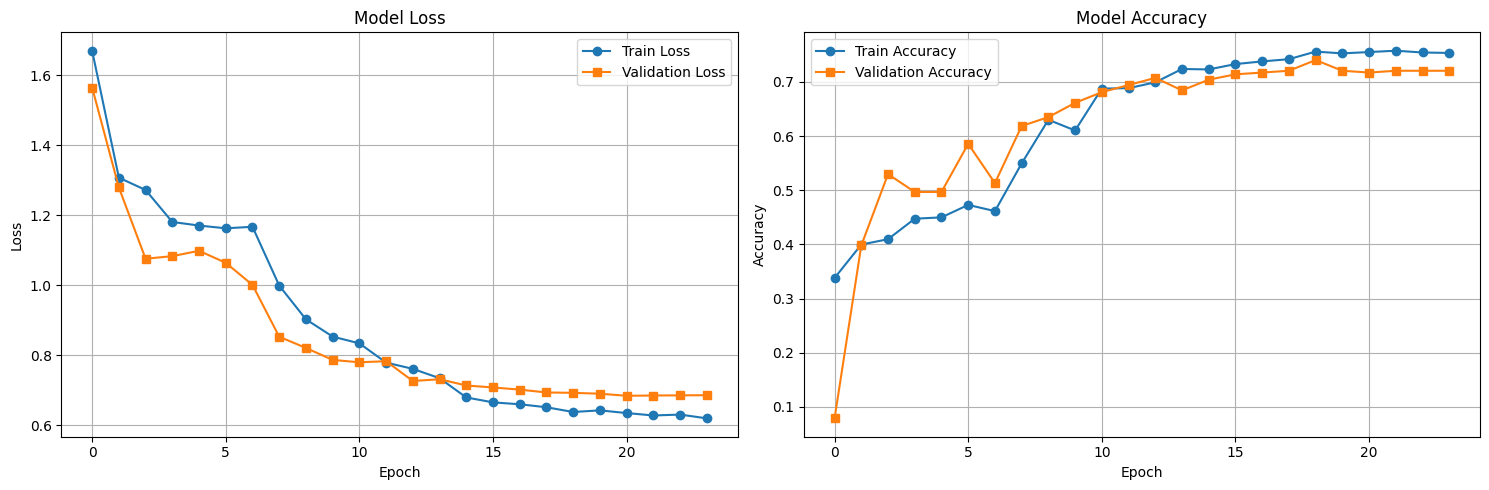

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.54it/s]


Test Accuracy: 21.16%
Test Loss: 2.1506

Classification Report:
              precision    recall  f1-score   support

         HGC       0.59      0.23      0.33        74
         LGC       0.13      0.15      0.14        53
         NST       0.17      0.19      0.18        37
         NTL       0.14      0.32      0.20        25

    accuracy                           0.21       189
   macro avg       0.26      0.22      0.21       189
weighted avg       0.32      0.21      0.23       189


Confusion Matrix:
[[17 31 22  4]
 [ 9  8 10 26]
 [ 1 10  7 19]
 [ 2 14  1  8]]

ROC-AUC Scores:
Macro-average AUC: 0.5350
Micro-average AUC: 0.5089
HGC AUC: 0.7093
LGC AUC: 0.2843
NST AUC: 0.4883
NTL AUC: 0.6583


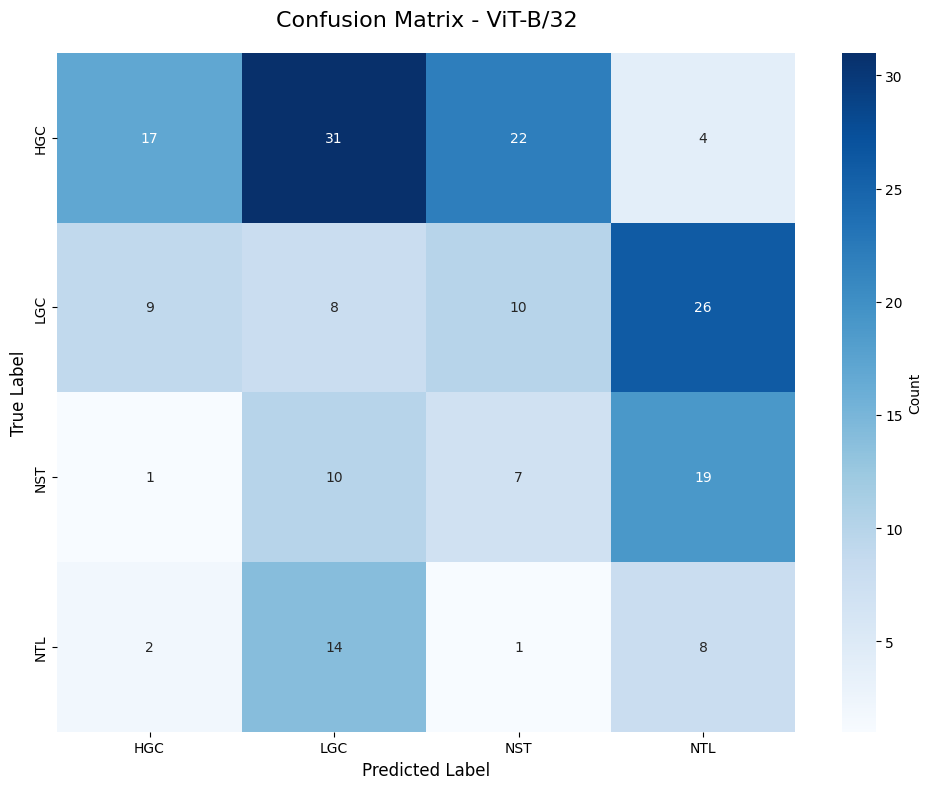

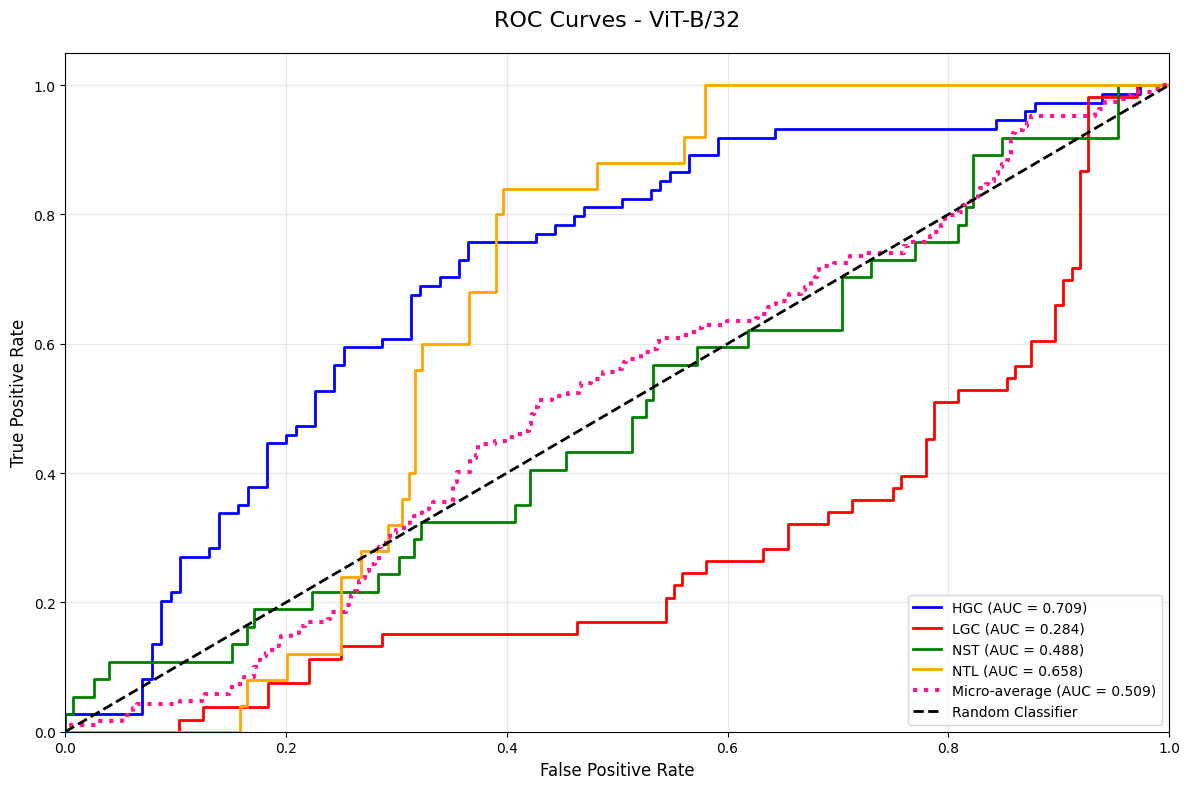


ViT-B/32 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training Vision Transformer B/32")
print("=" * 80)

# Create model
vit_b32 = create_vit_model(num_classes=4, pretrained=True, model_type='b32')

# Create trainer
trainer_vit_b32 = ModelTrainer(vit_b32, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vit_b32 = trainer_vit_b32.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ViT-B32")

# Plot training history
trainer_vit_b32.plot_training_history(save_path='vit_b32_training_history.png')

# Evaluate model
results_vit_b32 = trainer_vit_b32.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vit_b32['confusion_matrix'], class_names, 'ViT-B/32',
                      save_path='vit_b32_confusion_matrix.png')

# Plot ROC curves
roc_auc_vit_b32 = plot_roc_curves(results_vit_b32['labels'], results_vit_b32['probabilities'], class_names, 'ViT-B/32',
                                   save_path='vit_b32_roc_curves.png')

# Store results
results_vit_b32['model_name'] = 'ViT-B/32'
results_vit_b32['roc_auc'] = roc_auc_vit_b32
all_results.append(results_vit_b32)

print("\nViT-B/32 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ViT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: ViT_metrics.csv

Metrics Summary:
      Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  ViT-B/16         31.746032      1.693648             0.306930          0.408218      0.302580                0.335084              0.31746         0.285179       0.552632    0.283784  0.375000         74.0       0.068966    0.037736  0.048780         53.0       0.302326    0.351351  0.325000         37.0       0.303797        0.96  0.461538         25.0   0.672234   0.670586  0.819506  0.284684  0.750356  0.834390      0.819506      0.284684  